In [54]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [52]:
class Agent:
    def __init__(self, position):
        self.position = position
        self.energy = np.inf
        self.food_eaten = 0
        self.state = "active"

    def move(self, new_position):
        self.position = new_position
        
    def eat(self):
        self.food_eaten += 1

    def __repr__(self):
        return f"position={self.position}, state={self.state}"

In [70]:
class Environment:
    def __init__(self, size=20):
        self.size = size
        self.agents = []
        self.food = []  

    def generate_food(self, num=3):
        for _ in range(num):
            x = random.uniform(0, self.size)
            y = random.uniform(0, self.size)
            self.food.append((x, y))

    def add_agent(self, agent):
        self.agents.append(agent)

    def remove_agent(self, agent):
        self.agents.remove(agent)

    def move_agent(self, agent, new_position):
        agent.move(new_position)
        
    def visualize(self):
        fig, ax = plt.subplots()

        food_x, food_y = zip(*self.food)
        ax.scatter(food_x, food_y, c='red', label='Food')

        agent_x, agent_y = zip(*[agent.position for agent in self.agents])
        ax.scatter(agent_x, agent_y, c='blue', label='Agents')

        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')

        ax.legend()
        plt.pause(0.1)  
        plt.show() 
        
    def __repr__(self):
        return f"Agents: {self.agents}, Food: {self.food}"

In [71]:
env = Environment()

In [72]:
x = random.uniform(0, env.size)
y = random.uniform(0, env.size)
agent = Agent((x, y))
env.add_agent(agent)

In [73]:
env.generate_food()

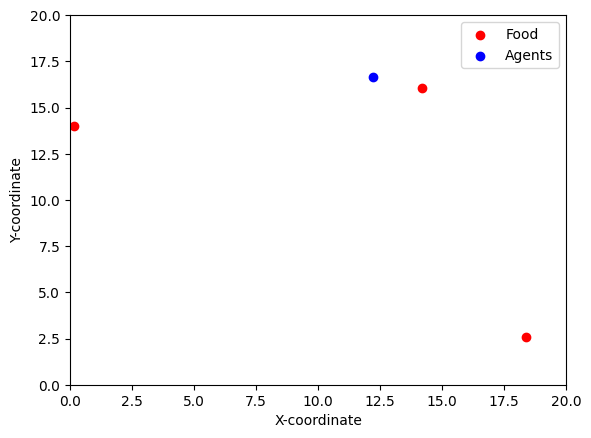

In [74]:
env.visualize()

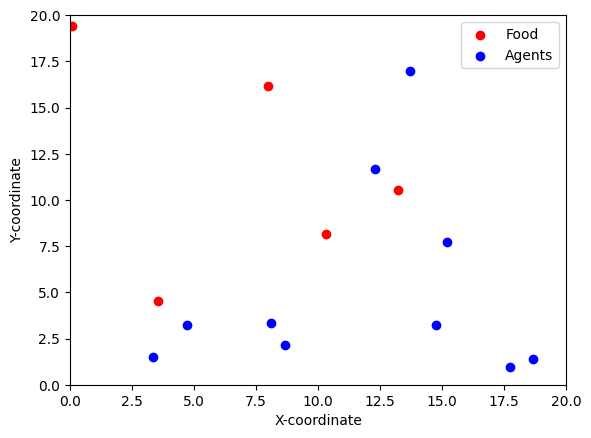

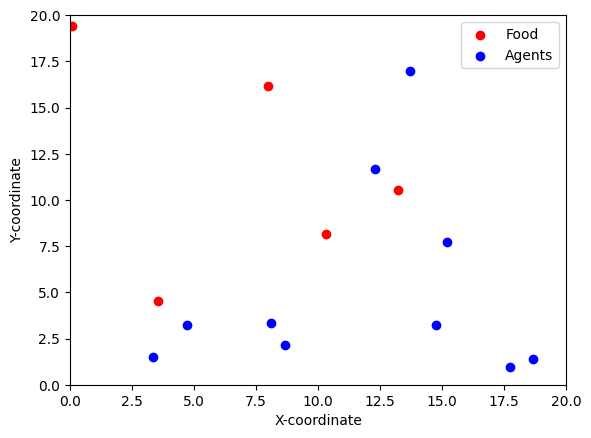

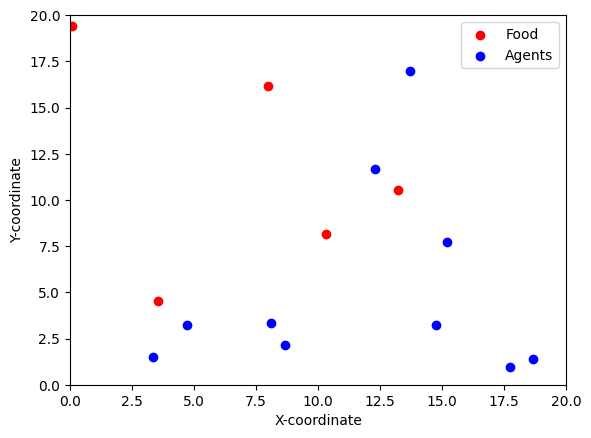

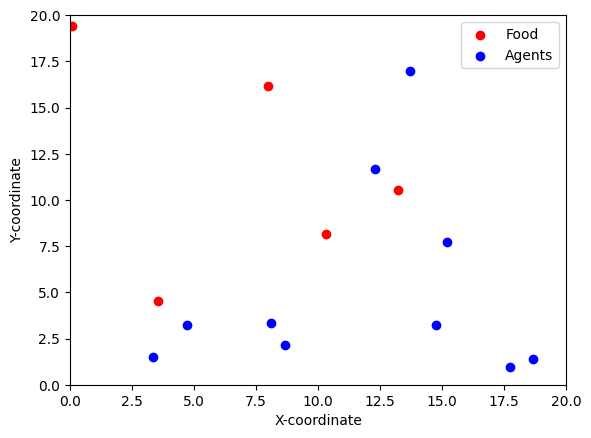

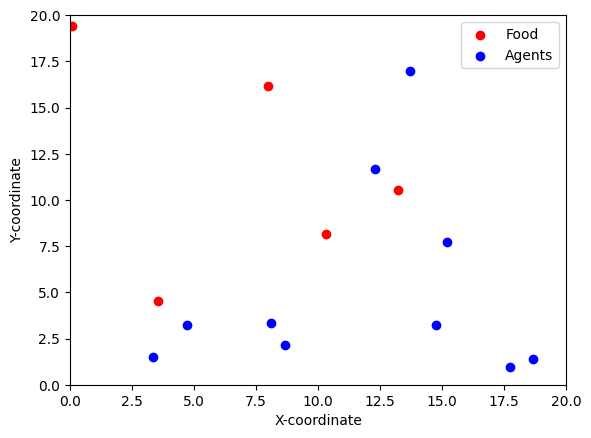

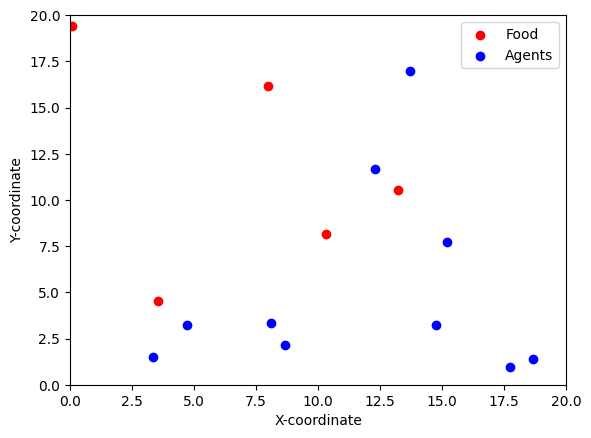

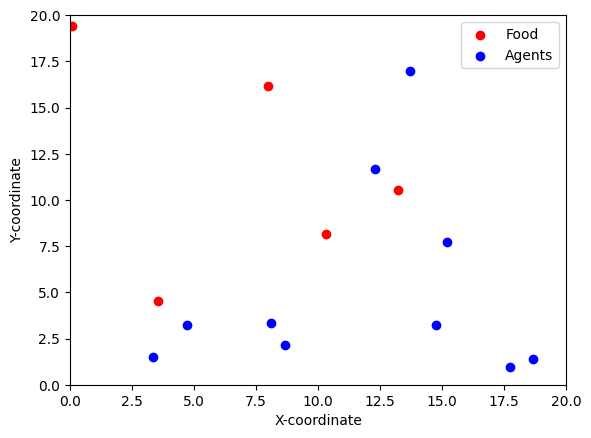

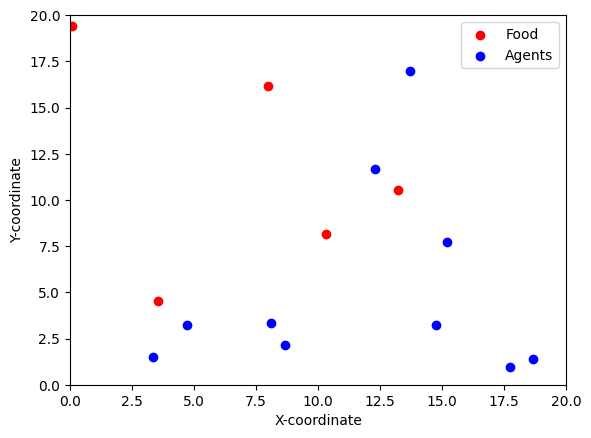

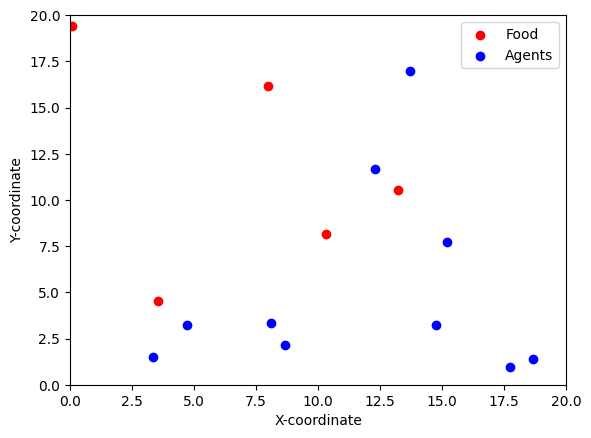

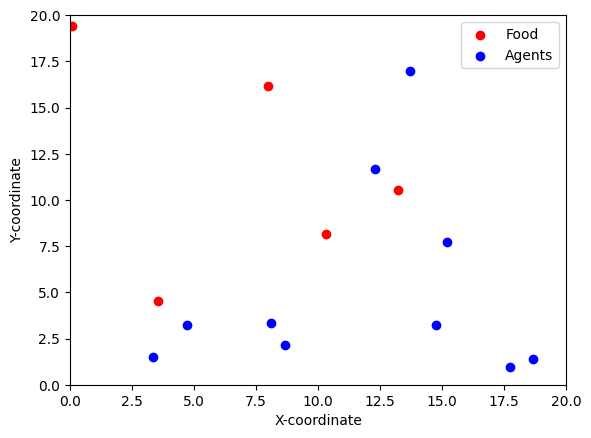

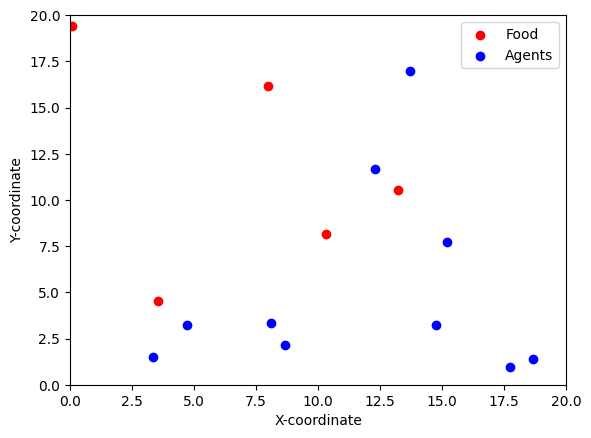

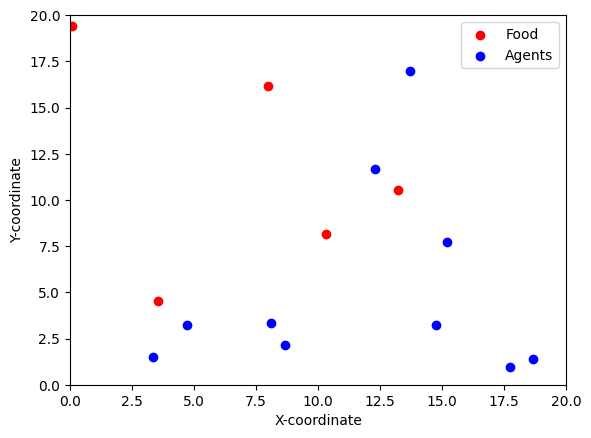

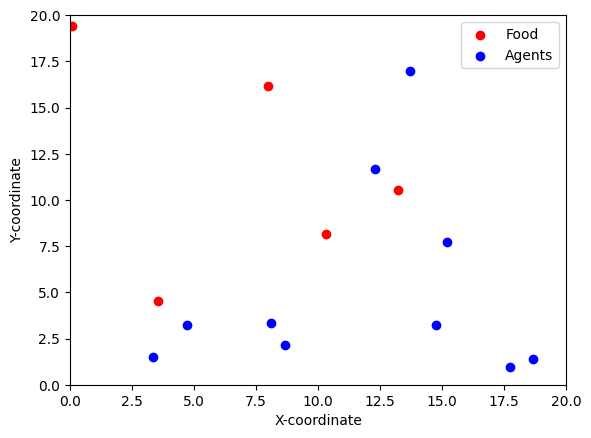

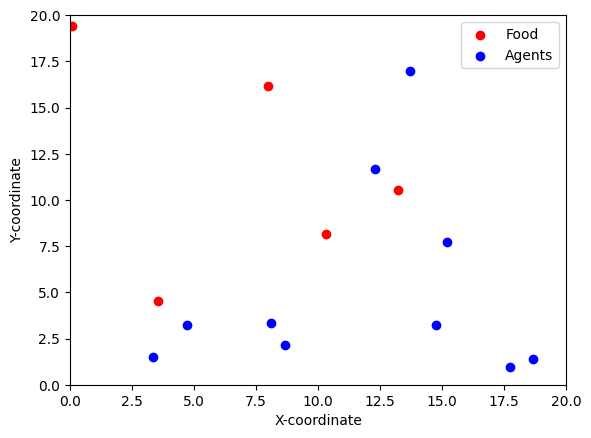

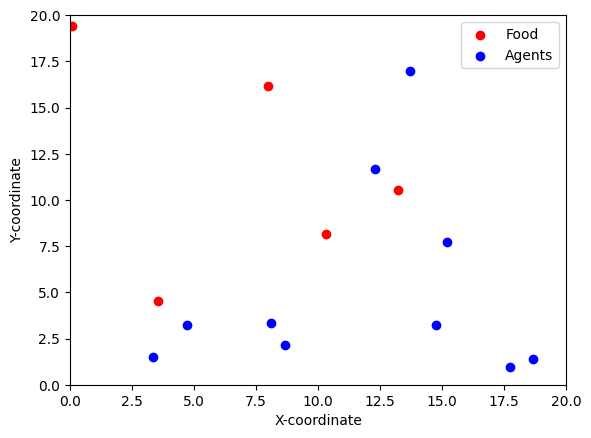

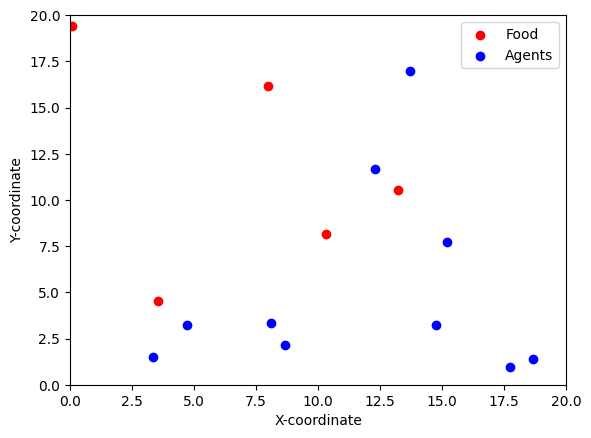

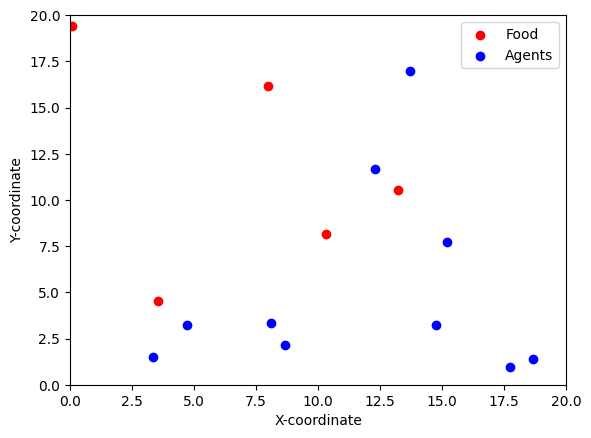

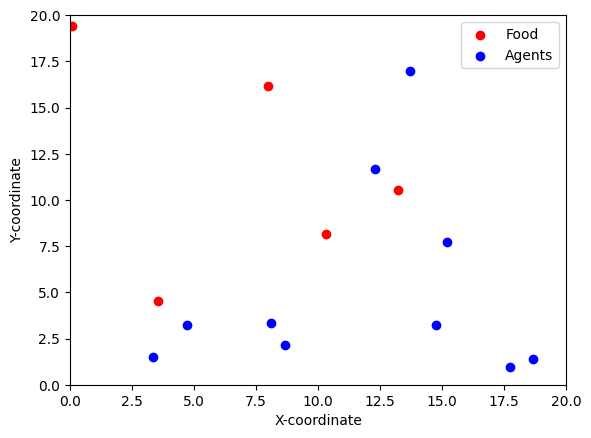

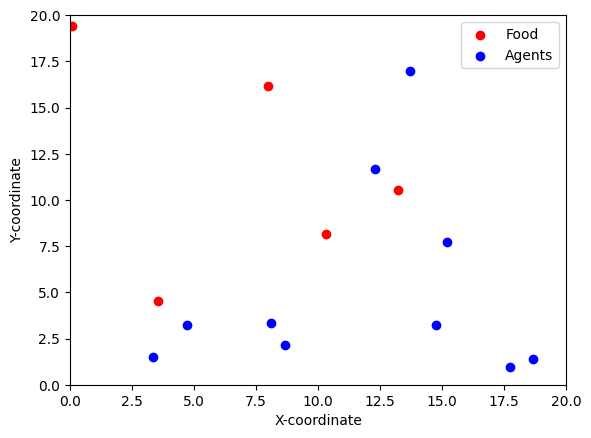

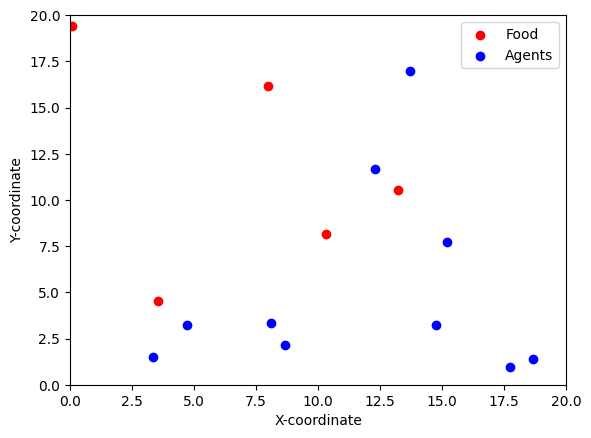

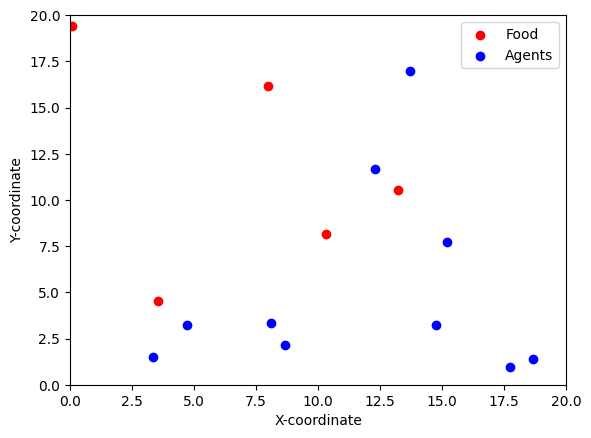

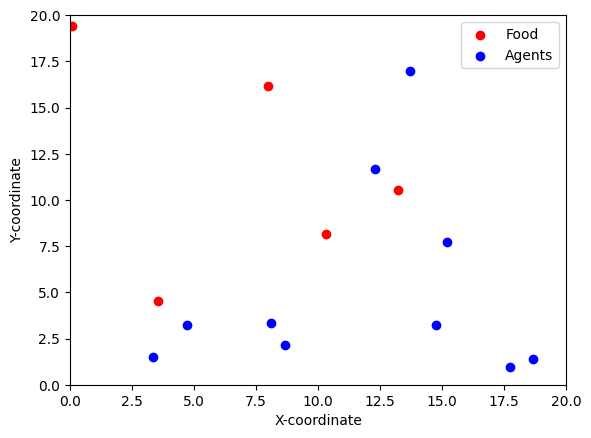

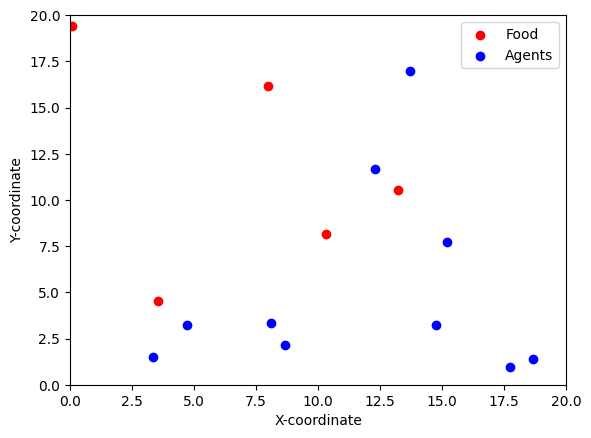

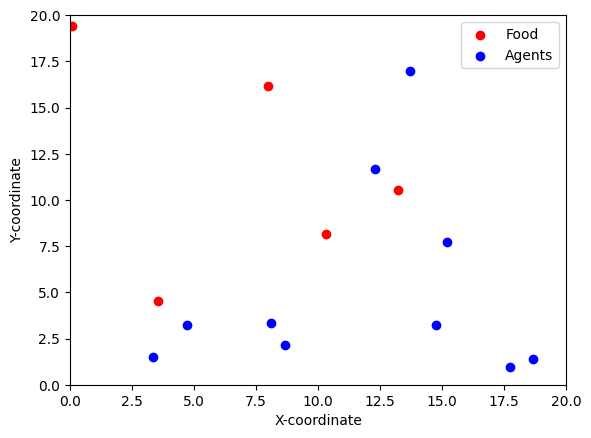

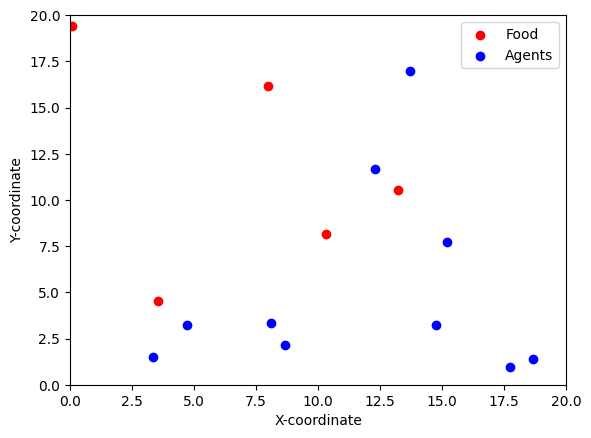

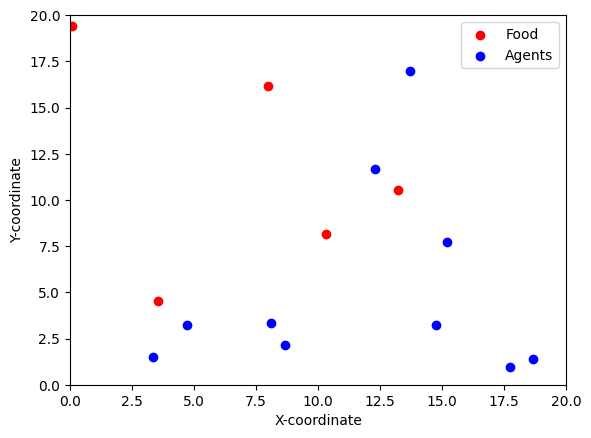

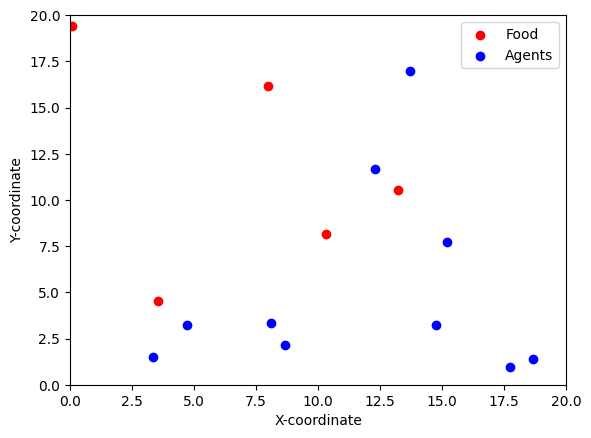

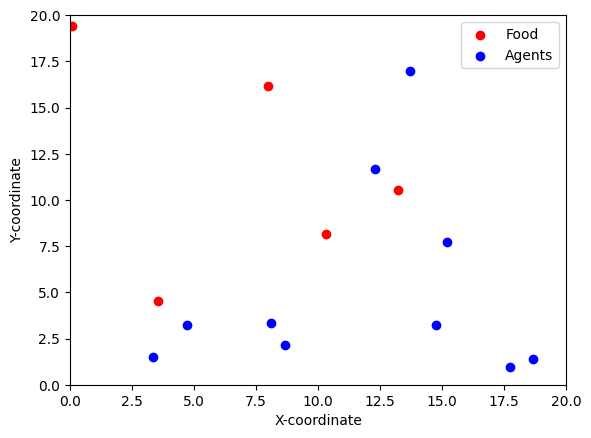

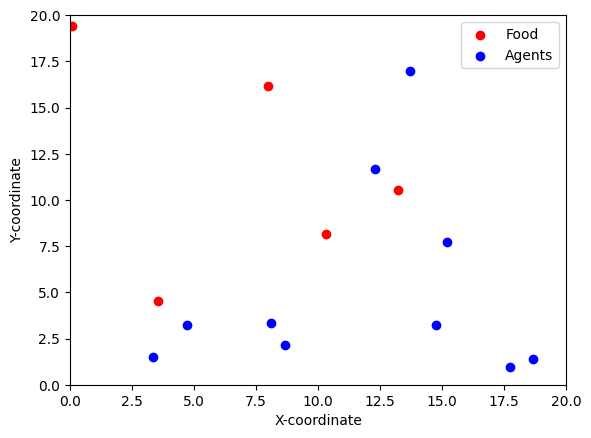

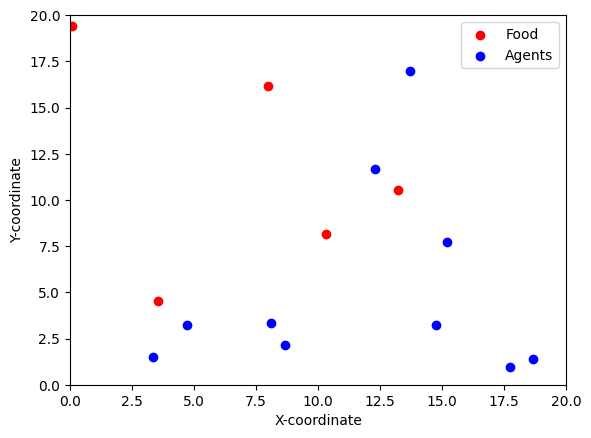

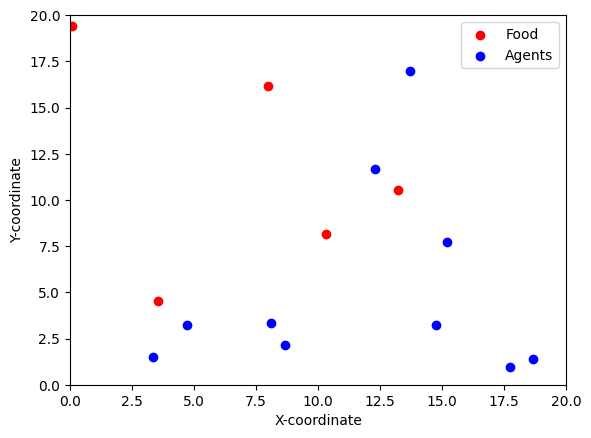

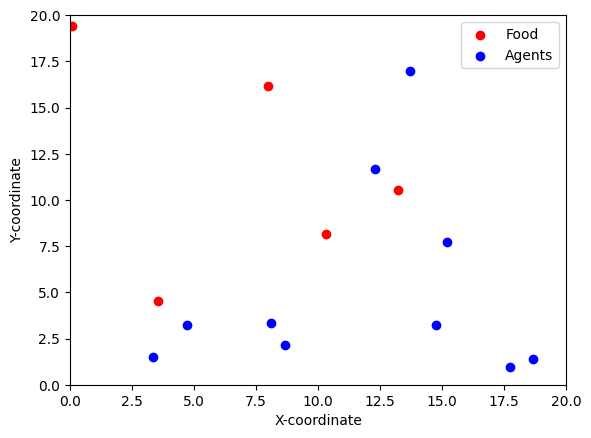

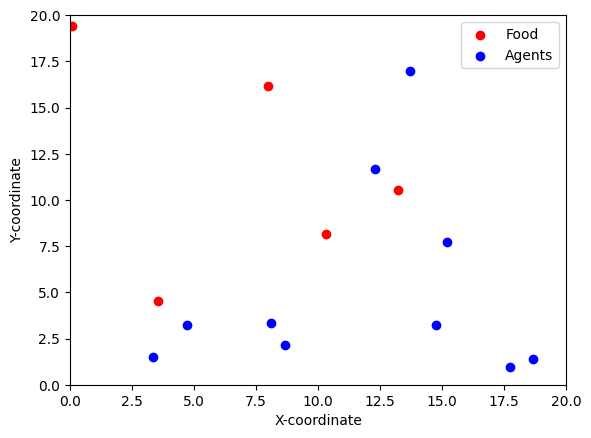

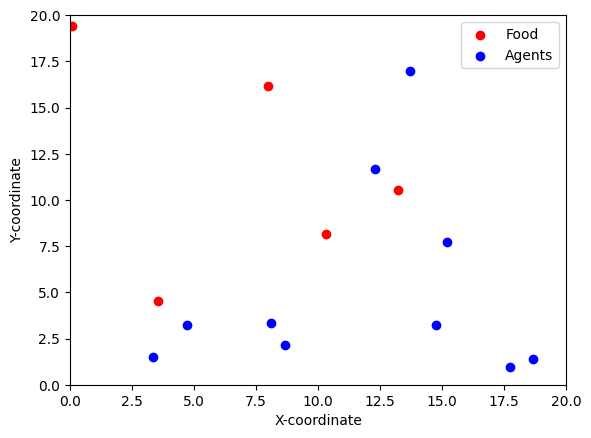

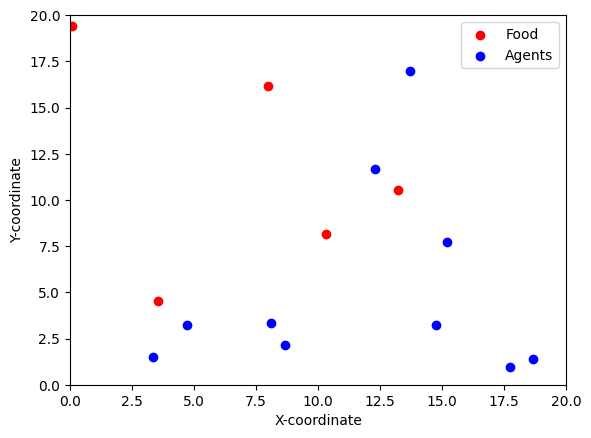

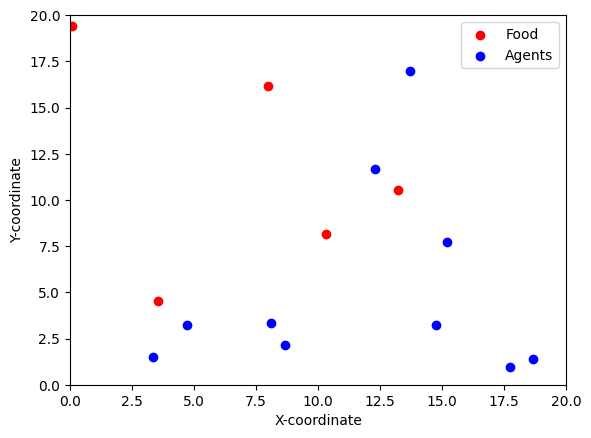

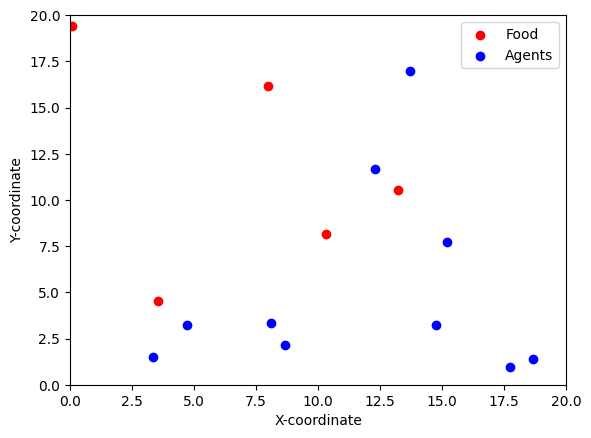

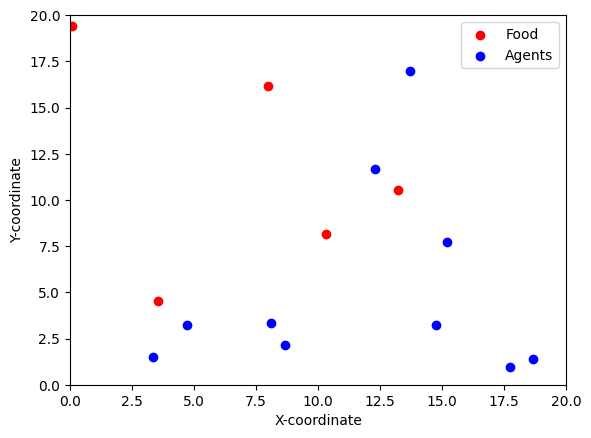

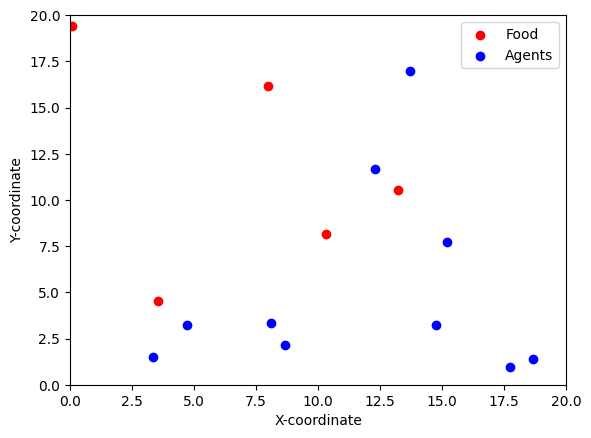

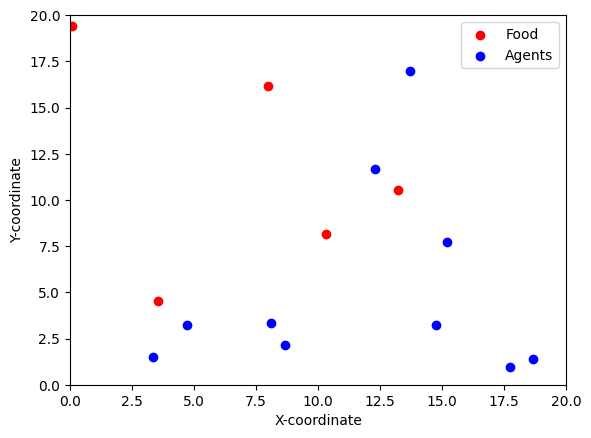

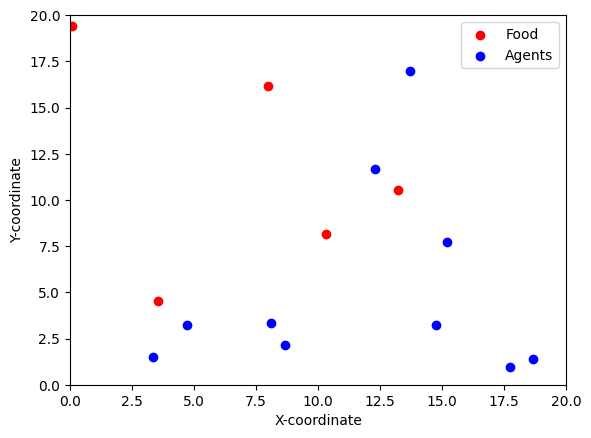

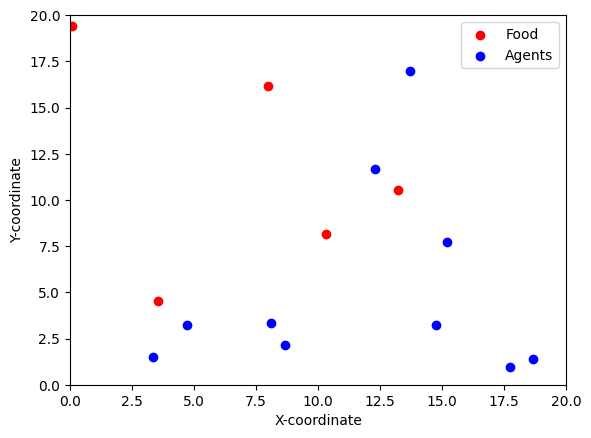

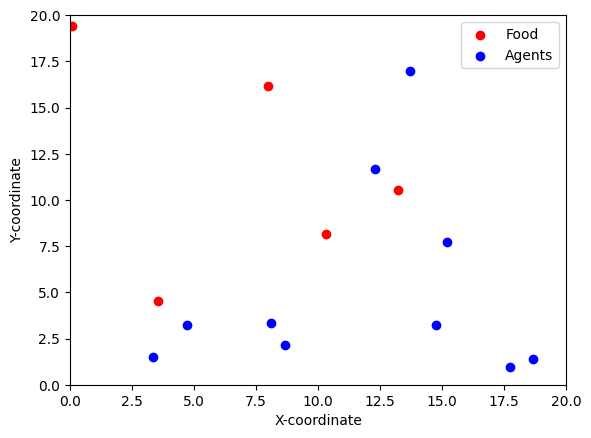

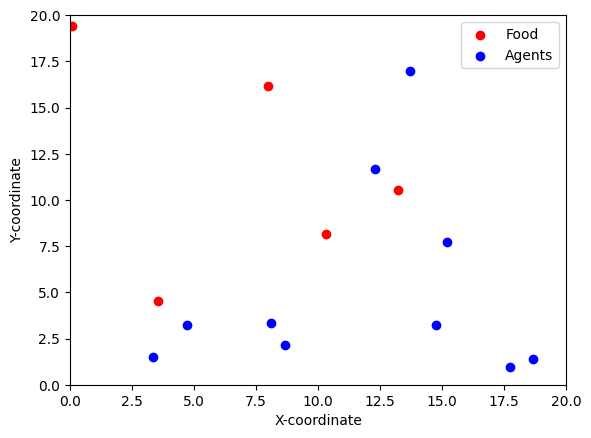

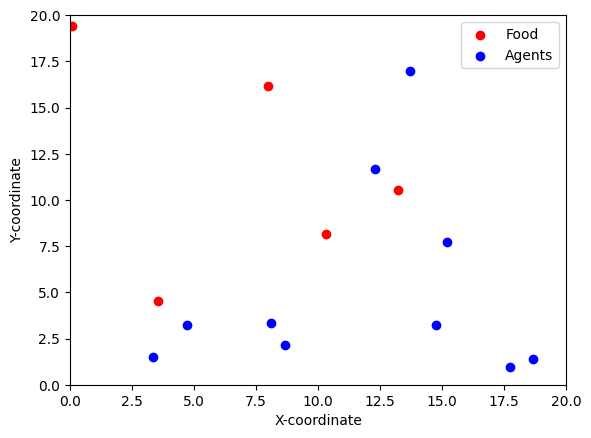

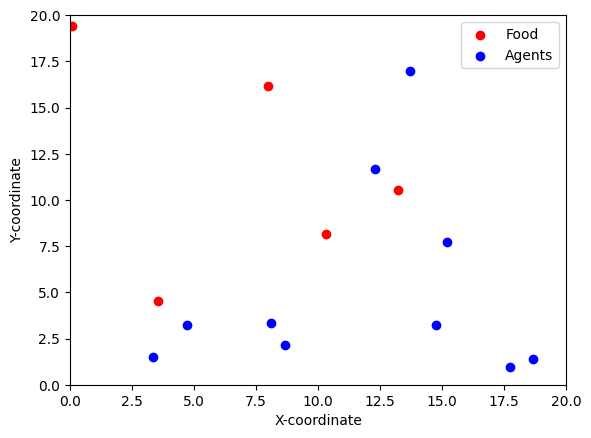

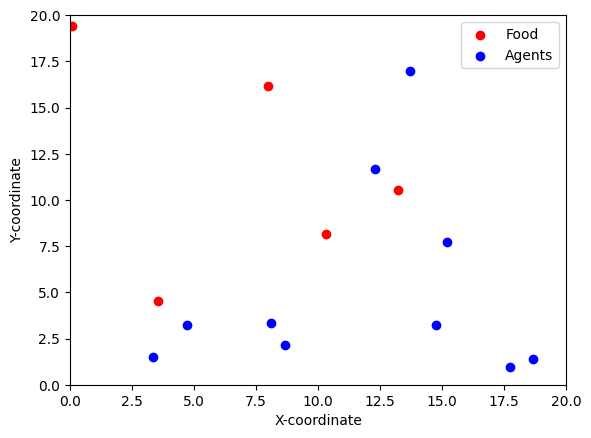

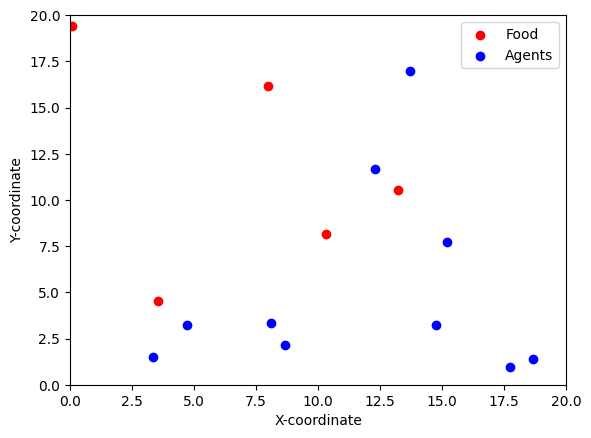

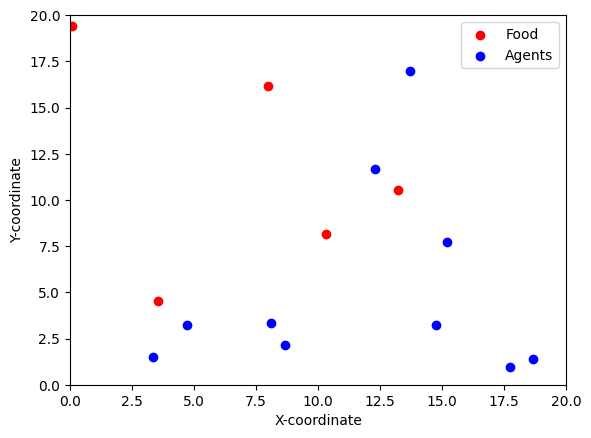

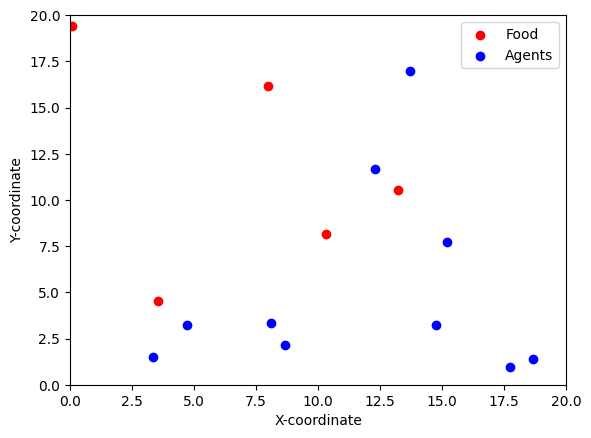

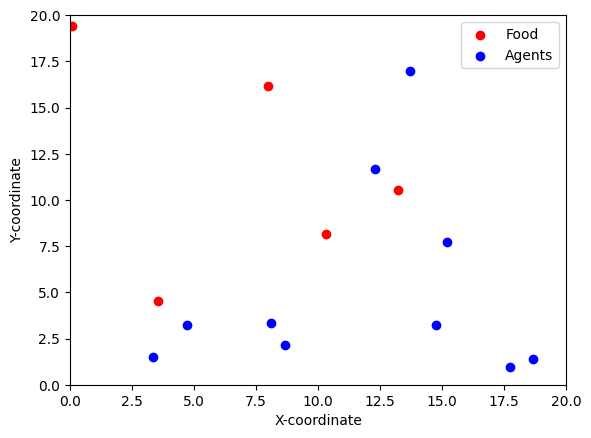

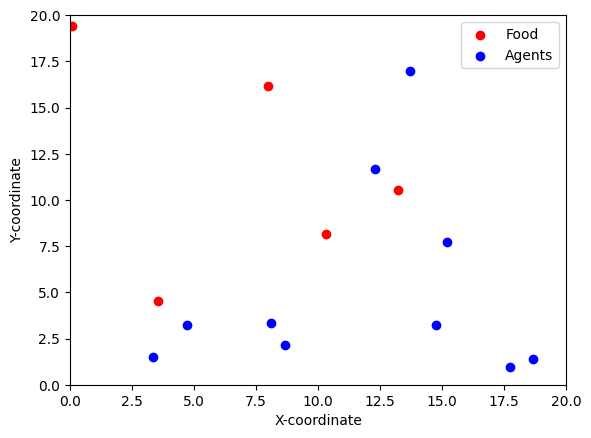

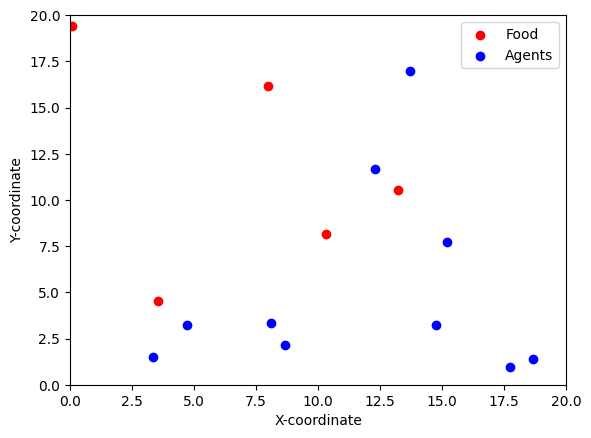

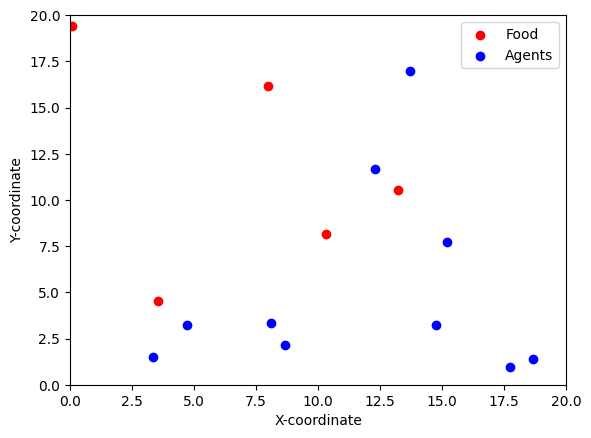

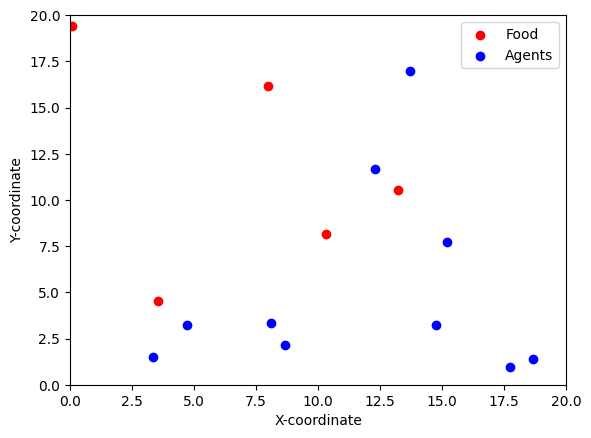

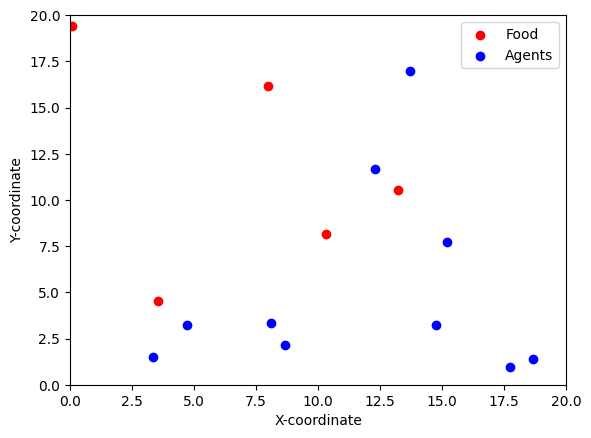

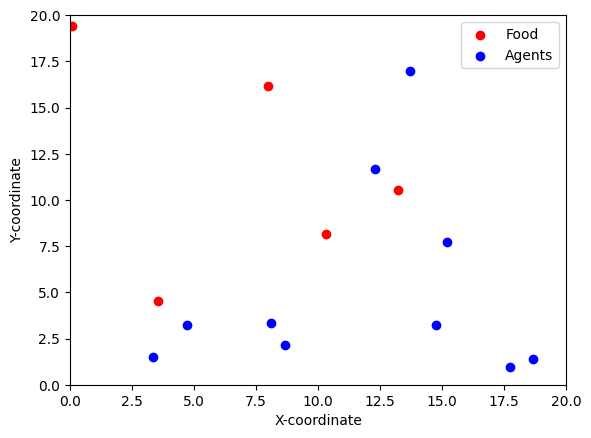

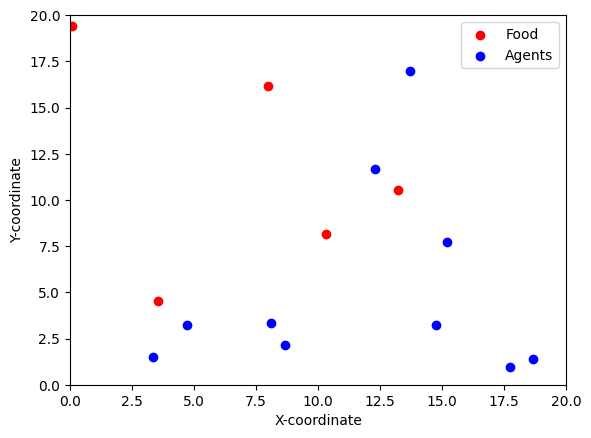

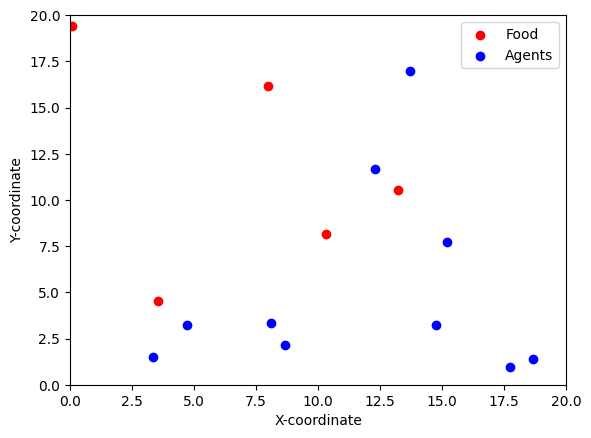

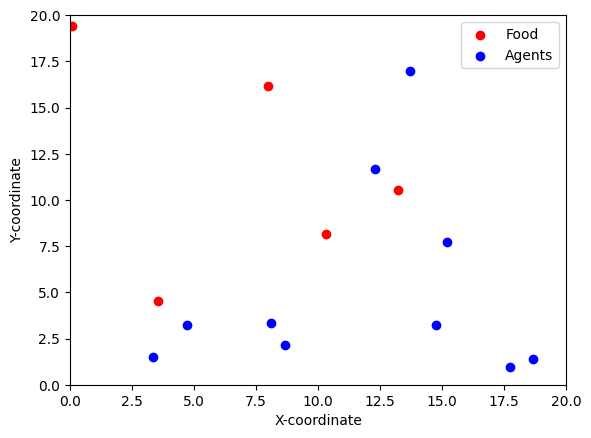

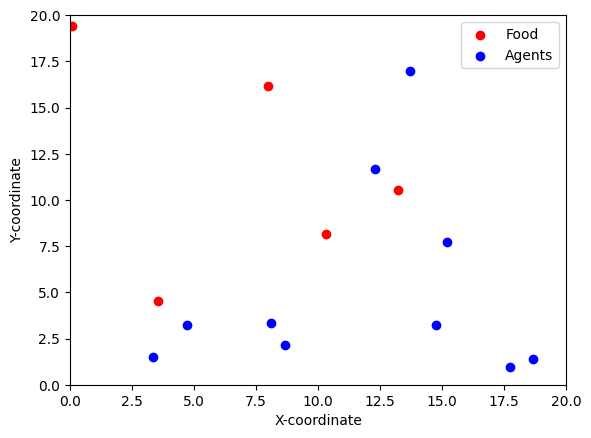

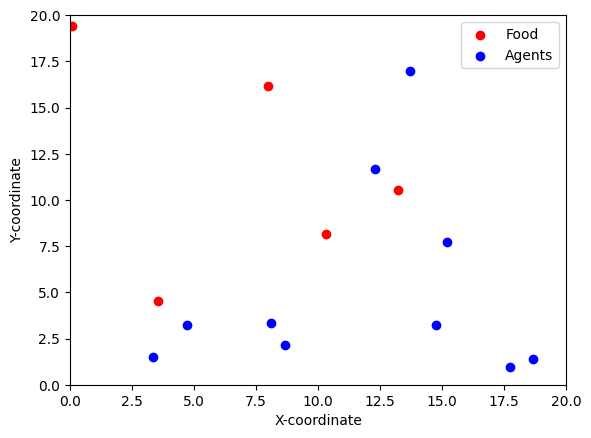

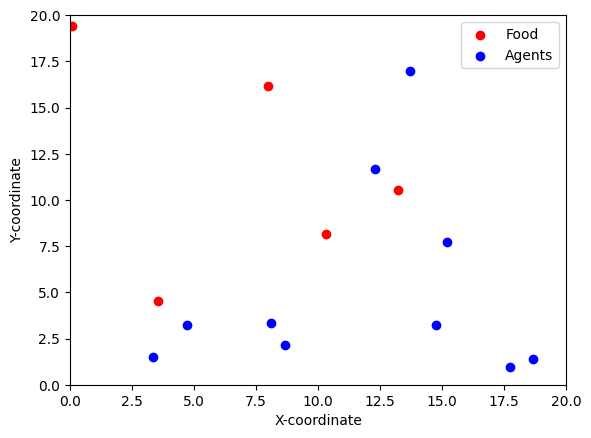

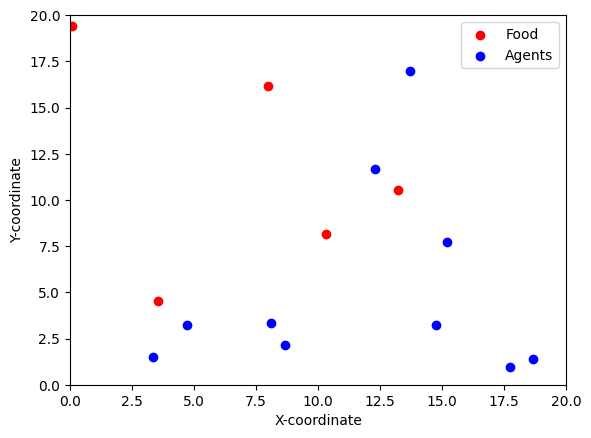

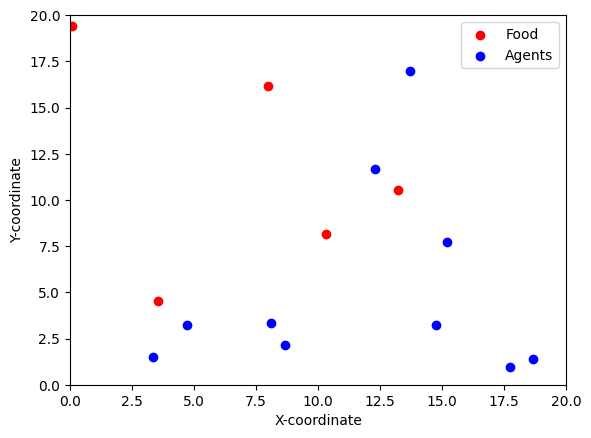

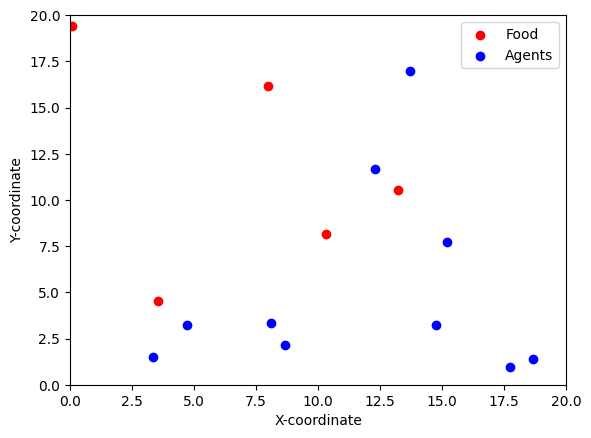

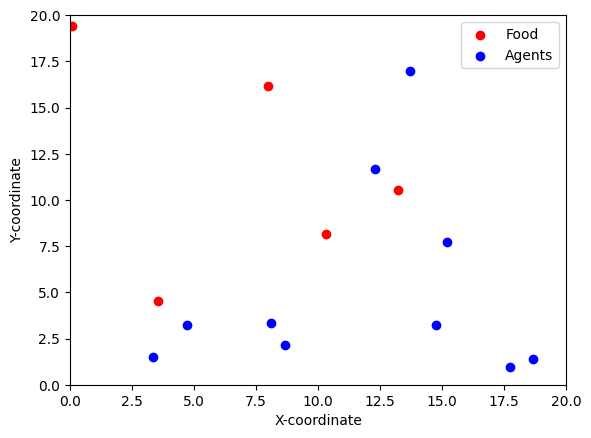

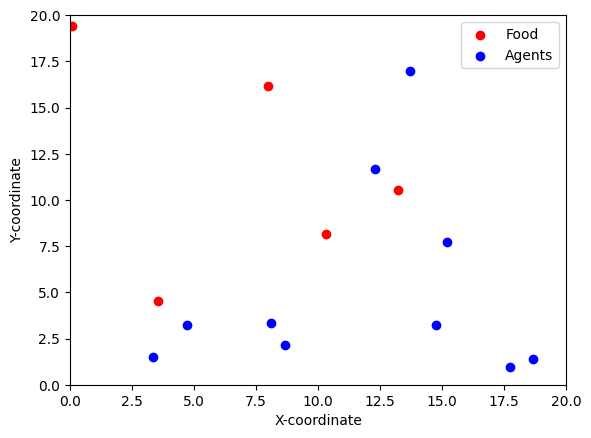

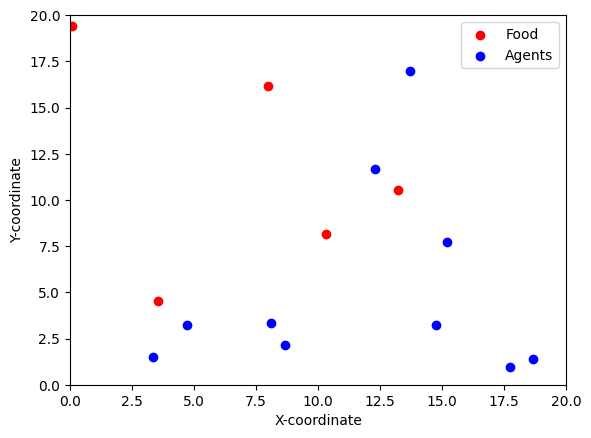

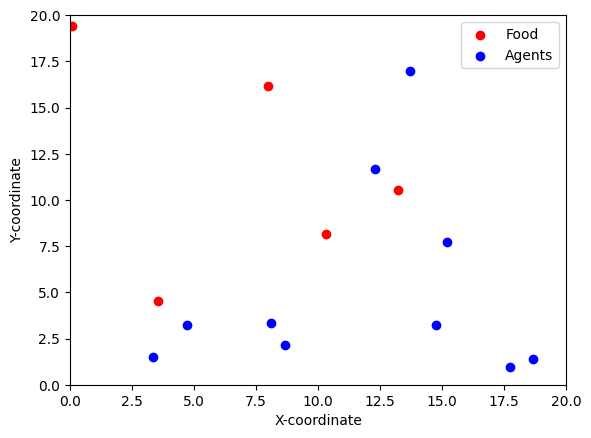

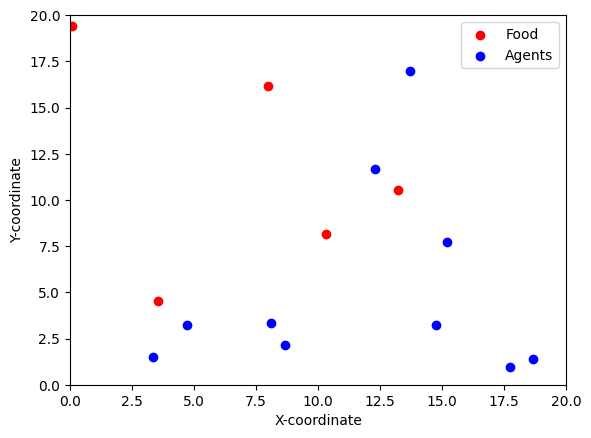

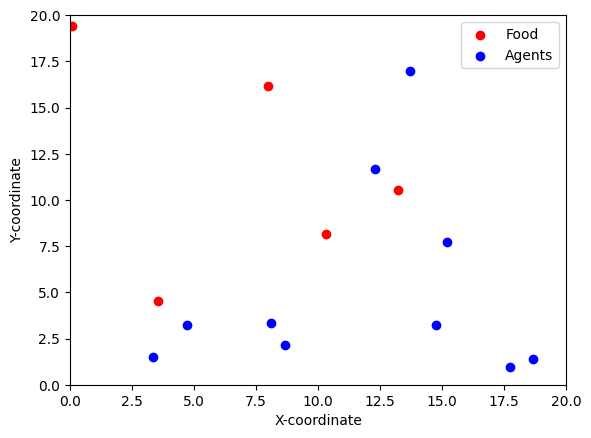

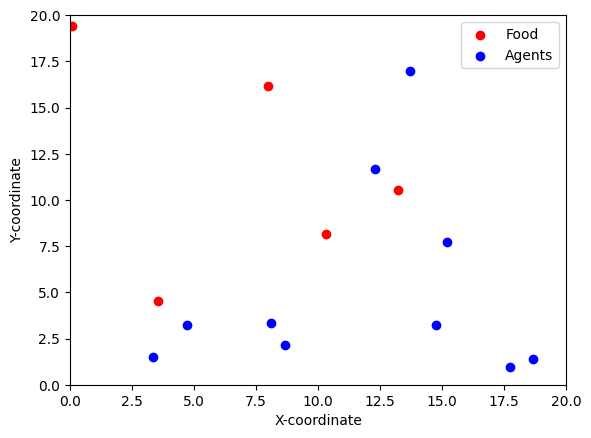

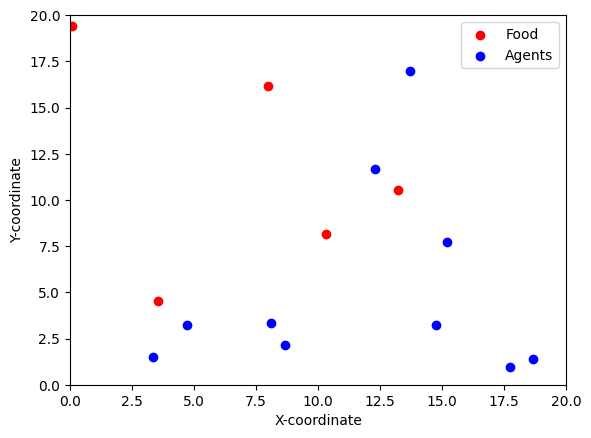

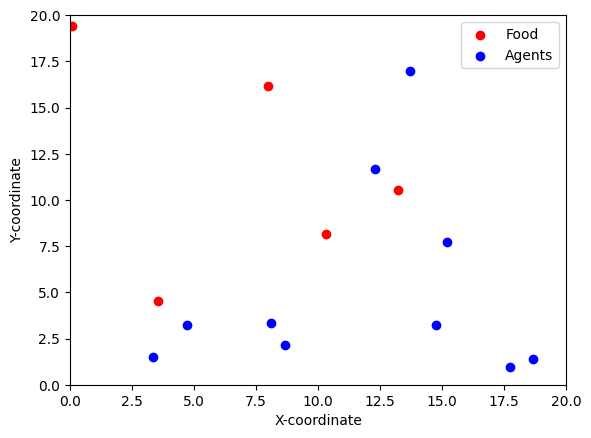

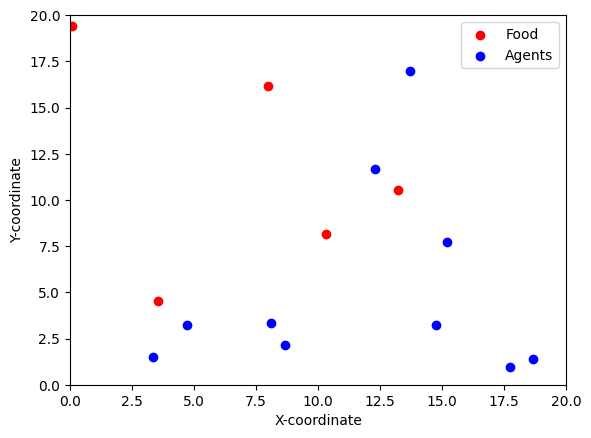

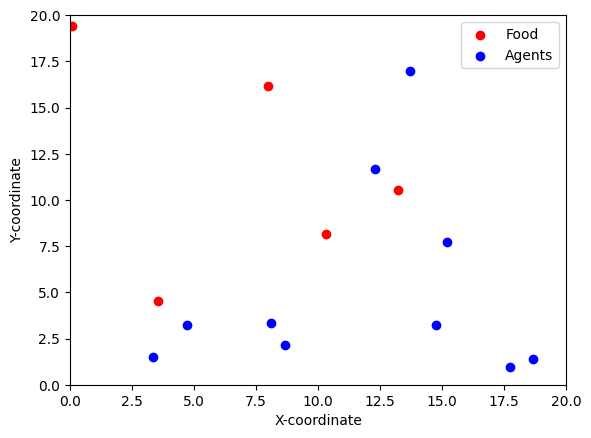

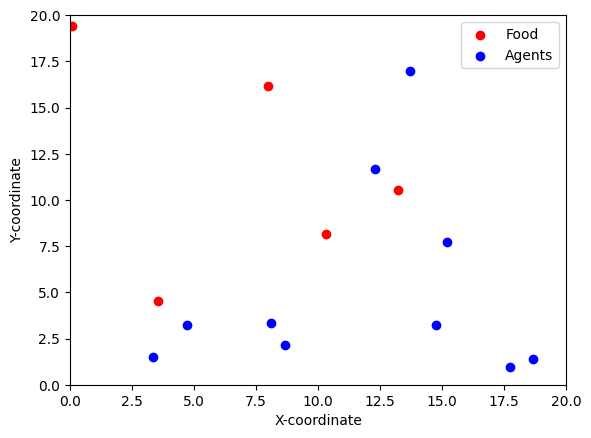

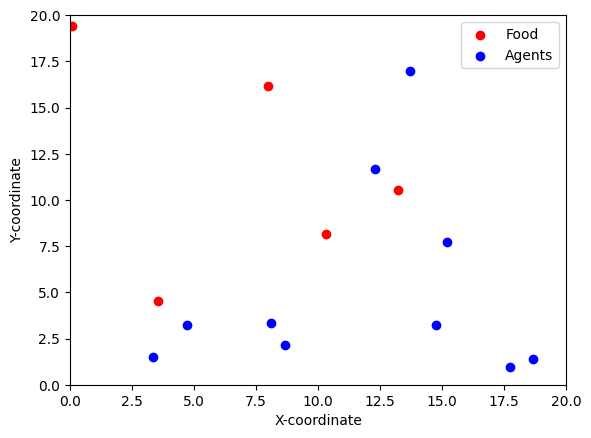

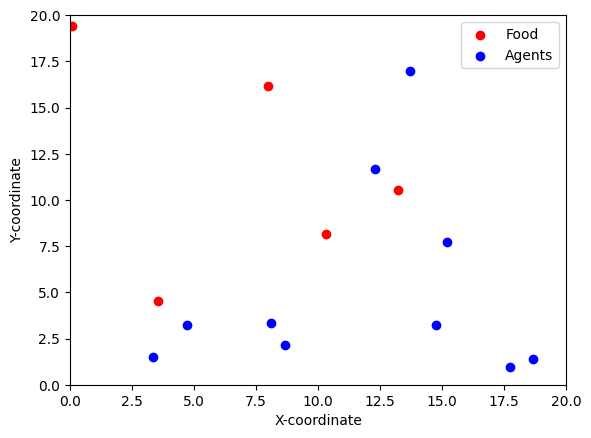

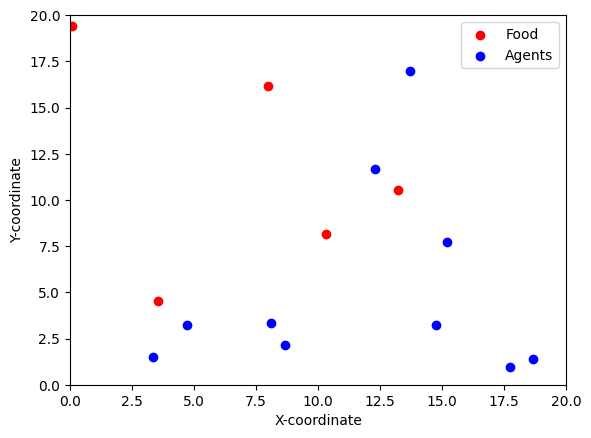

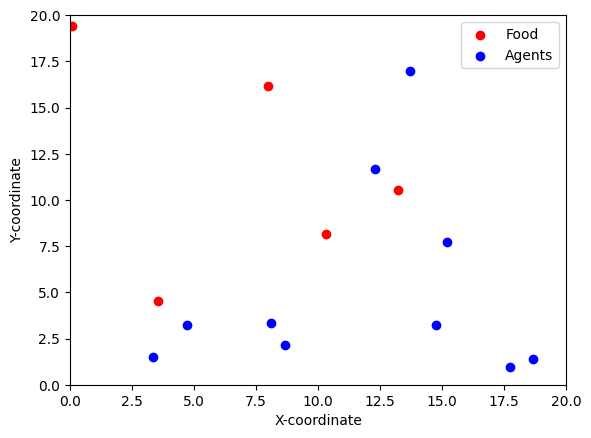

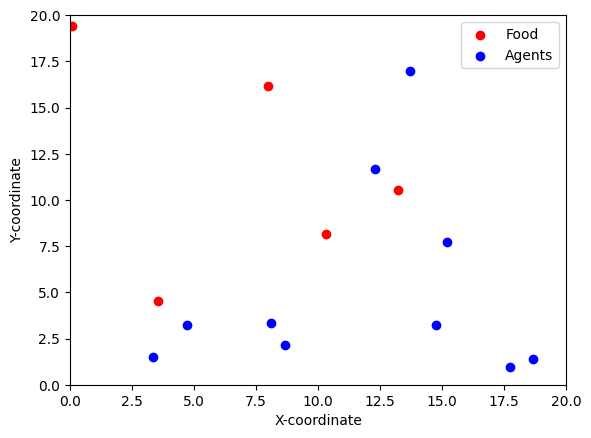

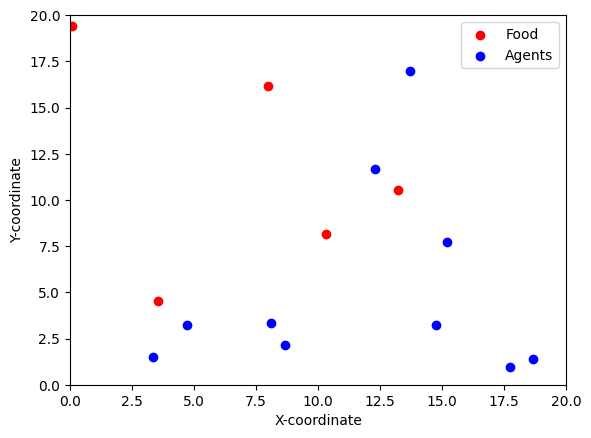

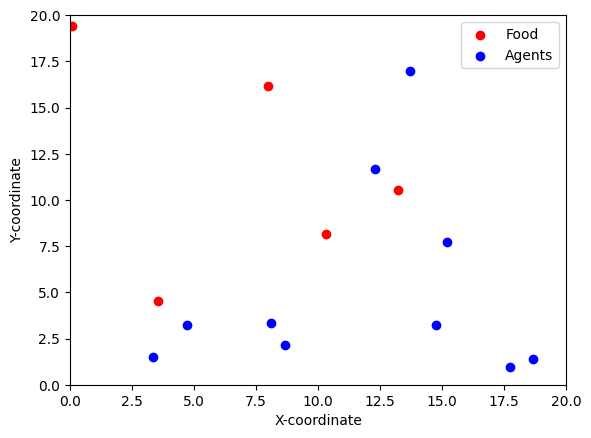

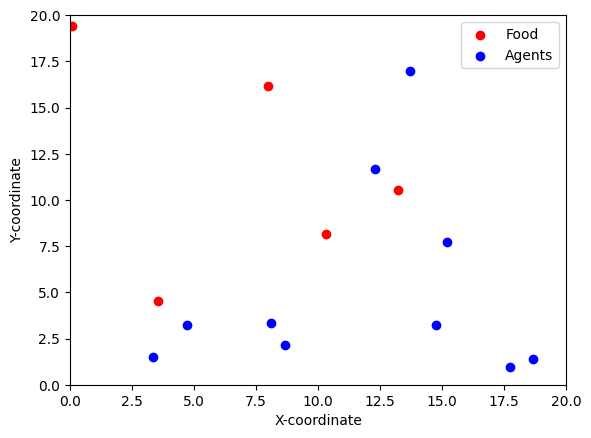

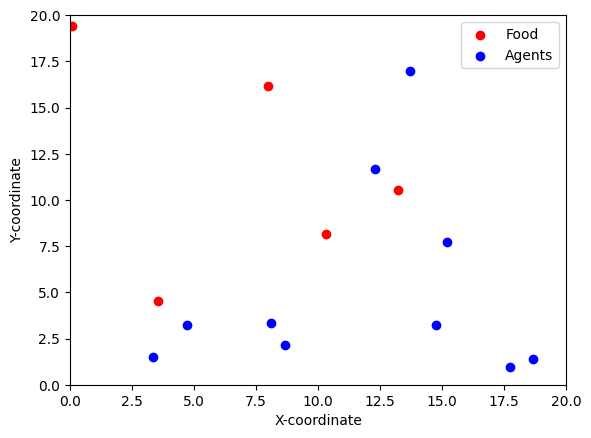

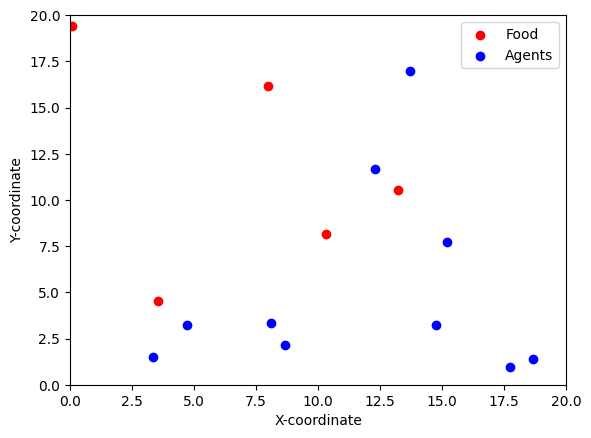

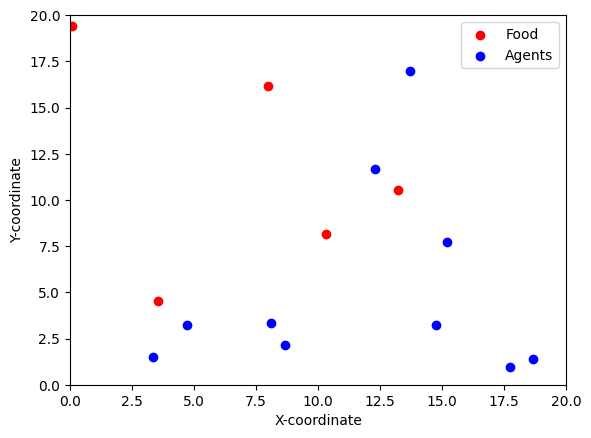

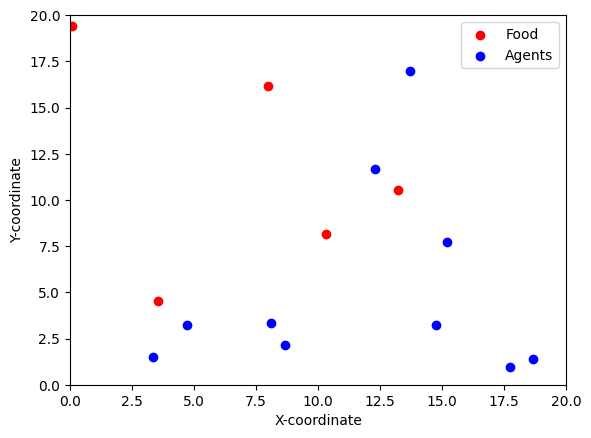

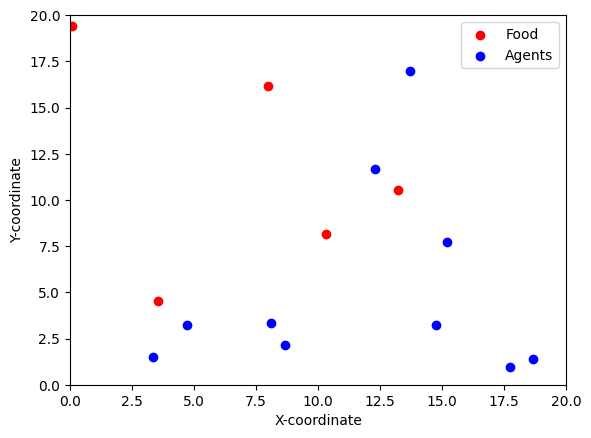

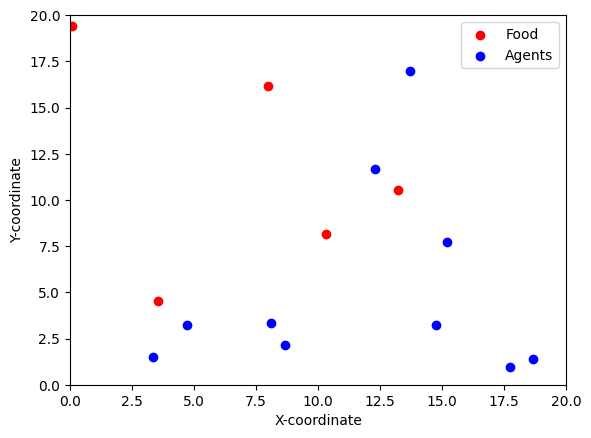

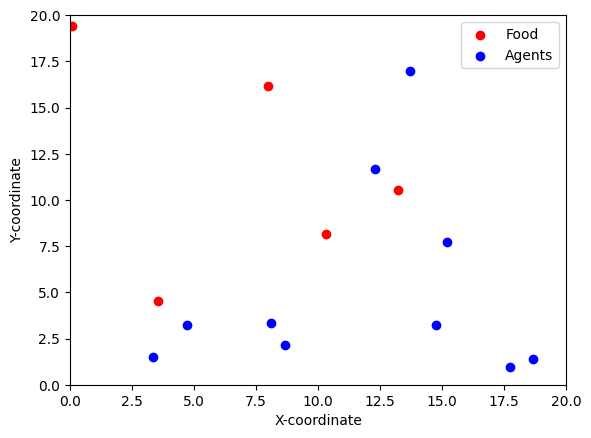

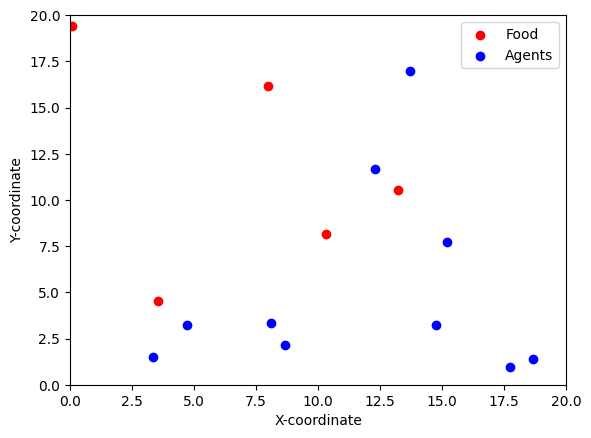

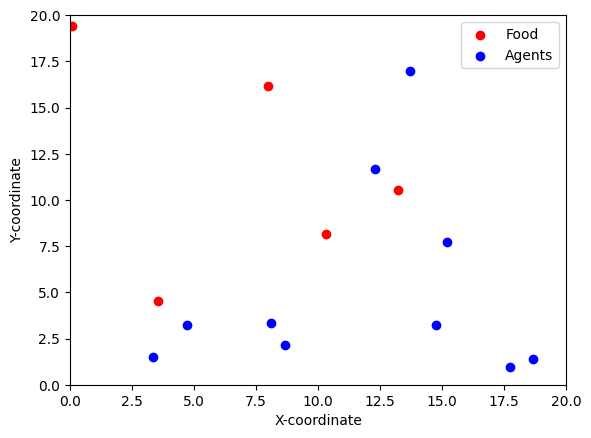

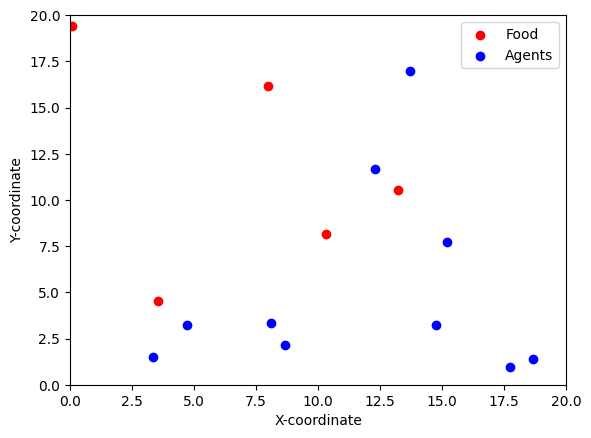

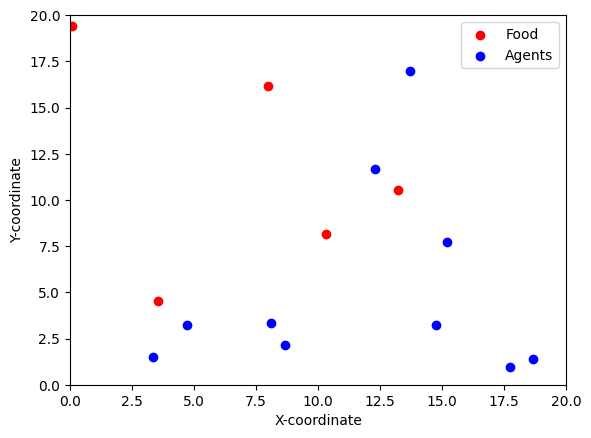

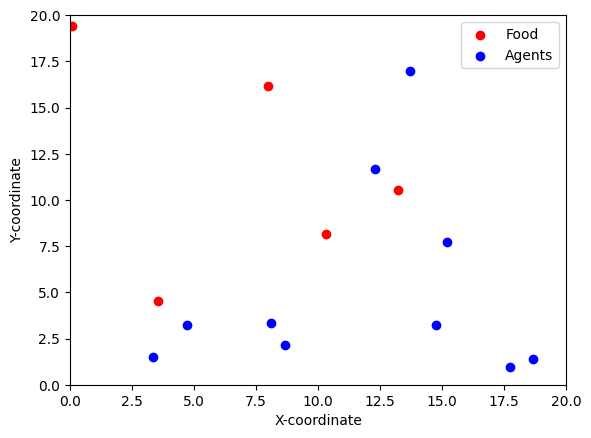

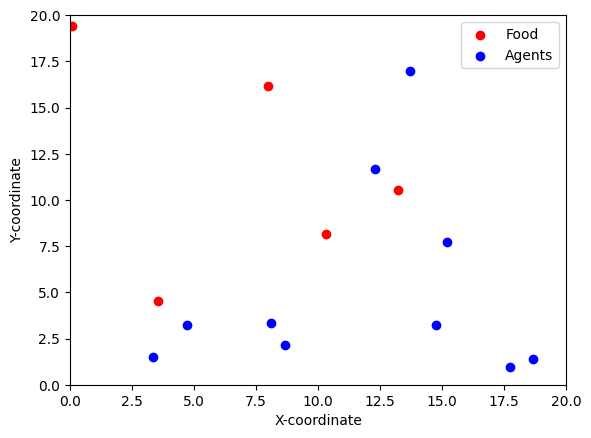

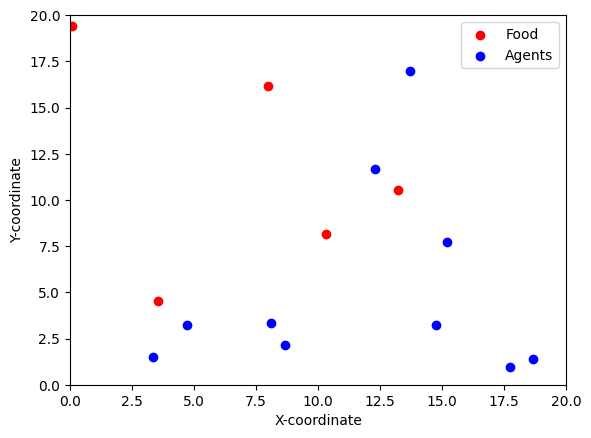

In [62]:
# Example usage:
env = Environment()

# Creating agents with random initial positions
for _ in range(10):
    x, y = random.uniform(0, env.size, 2)
    y = random.uniform(0, env.size)
    agent = Agent((x, y))
    env.add_agent(agent)

# Generating random food items
env.generate_food()

# Visualize the environment
for _ in range(100):  # Visualize for 100 iterations (you can change this)
    env.visualize()

plt.show()  # Ensure the final visualization remains open